# Network Analysis of Stations

This analysis serves to show how the county's fire stations interact with one another. More specifically, how often does Station A rely on another station to provide service in A's First Due?

By analyzing this information, we can see where gaps in the system would be devastating to service; thus enabling us to move resources if pivotal stations are overwhlemed or out of service.

In [ ]:
## Import data and libraries

import pandas as pd
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
data = pd.read_csv("/Users/holliknight/OneDrive - Prince George's County, Maryland/FirstWatch Data/DemandAllResponse/DemandAll_PBI_20210101_20210818.csv")

/Users/holliknight/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (36) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.shape

(166891, 41)

### Pre-Processing

In [7]:
## Get unit type from unit column in case we want to analyze by capabilities
data['UnitType'] = data['Unit #'].str.extract(r'([A-Z]{1,2})')

## Remove mutual aid calls
data = data.loc[data['Calculated Incident Area'].notna()]
data = data.loc[~data['Calculated Incident Area'].str.startswith('MA')]

## Get incident counts by Station and Incident Area
df = data.groupby(['Station', 'Calculated Incident Area'], as_index=False)['Incident #'].count()

## Formatting
df['Calculated Incident Area'] = df['Calculated Incident Area'].apply(lambda x: x.zfill(2))
df['Calculated Incident Area'] = '8' + df['Calculated Incident Area'].astype(str)

df.columns = ['Station', 'Area', 'Incidents']

df['Station'] = df['Station'].astype(int)
df['Area'] = df['Area'].astype(int)

## Remove admin or incorrect stations
df = df.loc[df['Station'] != 874]
df = df.loc[df['Area'] != 874]
df = df.loc[df['Area'] != 858]

df = df.loc[df['Station'] != 853]
df = df.loc[df['Station'] != 865]
df = df.loc[df['Station'] != 856]
df = df.loc[df['Station'] != 857]
df = df.loc[df['Station'] != 858]

### Build Network

In [37]:
G = nx.from_pandas_edgelist(df, 
                            source='Station',
                            target='Area',
                            edge_attr='Incidents',
                            create_using=nx.Graph())
                            

In [38]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 45
Number of edges: 743
Average degree:  33.0222


In [39]:
## Get station coordinates for mapping graph

stations = pd.read_excel("/Users/holliknight/Desktop/PGFD/Lookup Tables/Station Addresses LatLong.xlsx",index_col='Station')

pos_geo = {}
for node in G.nodes():
    pos_geo[node] = (
                    (min(stations.loc[node]['Longitude'],55)),
                    max(stations.loc[node]['Latitude'],25) 
    )

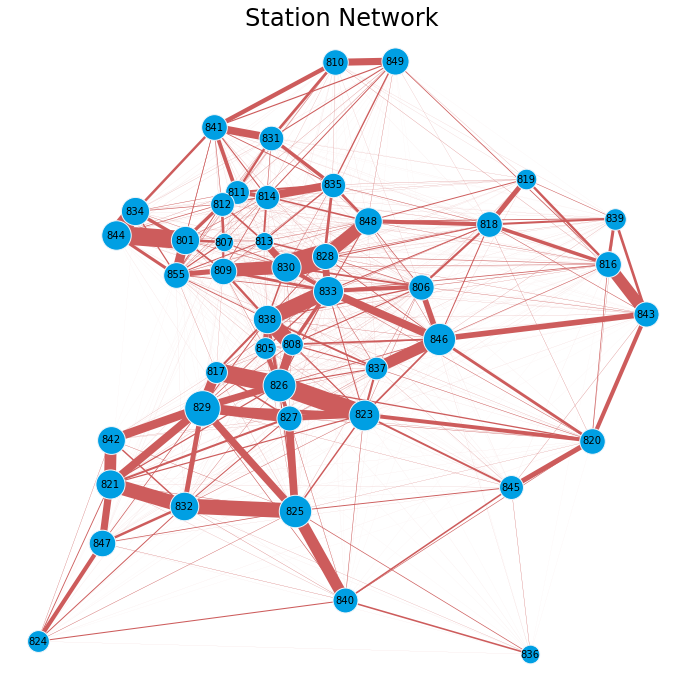

In [47]:
## Plotting graph

plt.rcParams['figure.figsize'] = [12, 12]
plt.axis('off')
plt.title('Station Network',fontsize = 24)


weighted_degrees = dict(nx.degree(G,weight='Incidents'))
max_degree = max(weighted_degrees.values())

pos = nx.spring_layout(G,weight='Incidents',iterations=20, k = 4)


for node in G.nodes():
    size = 10*weighted_degrees[node]**0.5
    ns = nx.draw_networkx_nodes(G,pos_geo,nodelist=[node], node_size=size, node_color='#009fe3')
    ns.set_edgecolor('#f2f6fa')

nx.draw_networkx_labels(G,pos_geo,font_size=10);

for e in G.edges(data=True):
    if e[2]['Incidents']>0:
        nx.draw_networkx_edges(G,pos_geo,[e],width=e[2]['Incidents']/60,edge_color='indianred')

In [48]:
G.nodes

NodeView((801, 811, 812, 813, 814, 818, 823, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 837, 838, 839, 841, 844, 846, 848, 849, 855, 806, 807, 808, 809, 805, 810, 816, 817, 820, 821, 824, 836, 840, 842, 843, 845, 819, 847))

### Analyzing Results

In [57]:
top = pd.DataFrame.from_dict(dict(nx.degree(G)),orient='index').sort_values(0,ascending=False)
top.columns = ['Degree']
top['Weighted Degree'] =  pd.DataFrame.from_dict(dict(nx.degree(G,weight='Incidents')),orient='index')
top['PageRank'] = pd.DataFrame.from_dict(dict(nx.pagerank_numpy(G,weight='Incidents')),orient='index')
top['Betweenness'] =  pd.DataFrame.from_dict(dict(nx.betweenness_centrality(G,weight='Incidents')),orient='index')
top['EigenCentrality'] = pd.DataFrame.from_dict(dict(nx.eigenvector_centrality(G,weight='Incidents')),orient='index')

In [58]:
top.sort_values(by='EigenCentrality', ascending=False)

,Degree,Weighted Degree,PageRank,Betweenness,EigenCentrality
829,35,16039,0.044407,0.016660,0.874677
826,41,11453,0.039695,0.041084,0.240901
825,31,11072,0.036027,0.011572,0.234038
823,40,8850,0.030175,0.034335,0.158832
821,26,7195,0.026366,0.007236,0.149044
827,35,3927,0.016766,0.040432,0.134862
832,32,6652,0.024170,0.036034,0.134505
842,21,5985,0.020343,0.003705,0.128485
817,26,2309,0.012859,0.009186,0.121159
840,26,3868,0.018325,0.034784,0.038432


A natural extension of degree centrality is eigenvector centrality. In-degree centrality awards one centrality point for every link a node receives. But not all vertices are equivalent: some are more relevant than others, and, reasonably, endorsements from important nodes count more. The eigenvector centrality thesis reads:

A node is important if it is linked to by other important nodes.
Eigenvector centrality differs from in-degree centrality: a node receiving many links does not necessarily have a high eigenvector centrality (it might be that all linkers have low or null eigenvector centrality). Moreover, a node with high eigenvector centrality is not necessarily highly linked (the node might have few but important linkers).

https://www.sci.unich.it/~francesc/teaching/network/eigenvector.html

Station 829 has a remarkably higher eigenvector centrality than any other station (more than 3 times higher than the next largest value). We know from practical experience that 829 is a very busy station, often producing our busiest units; however, it appears that many other stations "point toward" this station, and therefore the system relies heavily on its ability to produce / maintain operational capabilities.

In [1]:
import os
current_path = os.getcwd()

In [3]:
pwd

'/Users/holliknight/PGFD/Station and Unit Changes'

In [2]:
current_path

'/Users/holliknight/PGFD/Station and Unit Changes'

In [ ]:
'/Users/holliknight/PGFD/Station and Unit Changes/Network Analysis.ipynb'